https://youtu.be/iKqjee7yhsQ: Video explanation of strategy and code

In [2]:
import pandas_datareader as pdr
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#define date range
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2020, 12, 31)

YEARS = (END - START).days / 365.25

In [4]:
#define variables
STARTING_BALANCE = 10000
down_days = 1

In [5]:
#download data
price = pdr.get_data_yahoo('^GSPC', START, END)
price.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,3703.820068,3689.320068,3694.030029,3703.060059,1885090000,3703.060059
2020-12-28,3740.510010,3723.030029,3723.030029,3735.360107,3527460000,3735.360107
2020-12-29,3756.120117,3723.310059,3750.010010,3727.040039,3387030000,3727.040039
2020-12-30,3744.629883,3730.209961,3736.189941,3732.040039,3145200000,3732.040039
2020-12-31,3760.199951,3726.879883,3733.270020,3756.070068,3172510000,3756.070068


In [6]:
#drop redundant columns
price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], 1)
price.tail()

,Open,Close
Date,,
2020-12-24,3694.030029,3703.060059
2020-12-28,3723.030029,3735.360107
2020-12-29,3750.010010,3727.040039
2020-12-30,3736.189941,3732.040039
2020-12-31,3733.270020,3756.070068


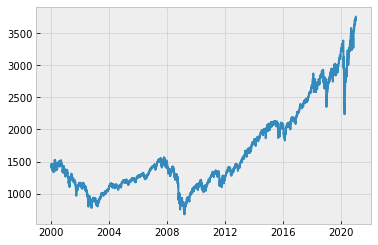

In [7]:
#plot chart
plt.style.use('bmh')
plt.plot(price.Close)
plt.show()

In [8]:
#calculate return and balance
price['oc'] = price.Close / price.Open
price['cc'] = price.Close / price.Close.shift(1)
price.cc.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.cc.cumprod()

In [9]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-56.78

In [10]:
#calculate additional columns for strategy

#check if today is a down day
price['Down'] = price.oc < 1

#count consecutive down days
#https://stackoverflow.com/questions/27626542/counting-consecutive-positive-value-in-python-array
down = price['Down']
price['Consecutive'] = down * (down.groupby((down != down.shift()).cumsum()).cumcount() + 1)

price.tail()

,Open,Close,oc,cc,Bench_Bal,Bench_Peak,Bench_DD,Down,Consecutive
Date,,,,,,,,,
2020-12-24,3694.030029,3703.060059,1.002444,1.003537,25446.737491,25580.187569,-133.450078,False,0
2020-12-28,3723.030029,3735.360107,1.003312,1.008723,25668.697397,25668.697397,0.000000,False,0
2020-12-29,3750.010010,3727.040039,0.993875,0.997773,25611.523440,25668.697397,-57.173957,True,1
2020-12-30,3736.189941,3732.040039,0.998889,1.001342,25645.882507,25668.697397,-22.814890,True,2
2020-12-31,3733.270020,3756.070068,1.006107,1.006439,25811.012383,25811.012383,0.000000,False,0


In [11]:
#identify entries and allocate trading fees
price['Long'] = price.Consecutive >= down_days

In [12]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.cc, 1)
price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()

price.tail()

,Open,Close,oc,cc,Bench_Bal,Bench_Peak,Bench_DD,Down,Consecutive,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,
2020-12-24,3694.030029,3703.060059,1.002444,1.003537,25446.737491,25580.187569,-133.450078,False,0,False,1.003537,80816.150262
2020-12-28,3723.030029,3735.360107,1.003312,1.008723,25668.697397,25668.697397,0.000000,False,0,False,1.000000,80816.150262
2020-12-29,3750.010010,3727.040039,0.993875,0.997773,25611.523440,25668.697397,-57.173957,True,1,True,1.000000,80816.150262
2020-12-30,3736.189941,3732.040039,0.998889,1.001342,25645.882507,25668.697397,-22.814890,True,2,True,1.001342,80924.568939
2020-12-31,3733.270020,3756.070068,1.006107,1.006439,25811.012383,25811.012383,0.000000,False,0,False,1.006439,81445.629738


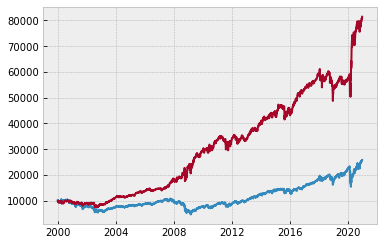

In [13]:
#plot results
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal)

plt.show()

In [14]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-26.88

In [15]:
#calculate metrics
bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal[-1]/price.Sys_Bal[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 158.11%
Benchmark CAGR: 4.62
Benchmark DD: -56.78%

System Total return: 714.46%
System CAGR: 10.5
System DD: -26.88%
Time in Market: 46.0%
Trades Won: 1398
Trades Loss: 1057
Winrate: 56.95%


In [16]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225']

In [17]:
def backtest(symbol):
    #download data
    price = pdr.get_data_yahoo(symbol, START, END)
    
    #drop redundant columns
    price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], 1)
    
    #calculate return and balance
    price['oc'] = price.Close / price.Open
    price['cc'] = price.Close / price.Close.shift(1)
    price.cc.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.cc.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    #check if today is a down day
    price['Down'] = price.oc < 1

    #count consecutive down days
    #https://stackoverflow.com/questions/27626542/counting-consecutive-positive-value-in-python-array
    down = price['Down']
    price['Consecutive'] = down * (down.groupby((down != down.shift()).cumsum()).cumcount() + 1)
    
    price['Long'] = price.Consecutive >= down_days

    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.cc, 1)
    price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
  
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr

In [18]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

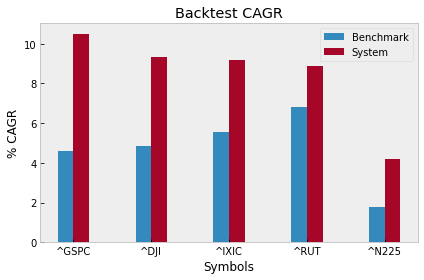

In [26]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark')
plt.bar(x_indices + width / 2, sc, width = width, label = 'System')
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.grid(False)
plt.savefig('saved_figure.png', dpi=500)

plt.show()
